In [1]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
spdatapath='./inputQuery/'
ad_spatial_ori=sc.read(spdatapath+'gene_by_cell.csv').transpose()
coordinate = pd.read_csv(spdatapath+'tissue_positions_list.csv')
coordinate=coordinate.to_numpy()

#because it is 2d tissue slide so only upload the X and Y coordiante 
ad_spatial_ori.obsm['spatial']=coordinate[:,[1,2]].astype(float)
adata=ad_spatial_ori
sample=[]
for i in range(len(ad_spatial_ori.obs_names)):
    sample.append('intestine')


df=pd.read_csv(spdatapath+'MNN_based_annotations/3_nico_annotation_ct_name.csv')
sc_ctype_name=df.to_numpy()

df=pd.read_csv(spdatapath+'MNN_based_annotations/3_nico_annotation_cluster.csv')
nico_cluster=df.to_numpy()
cellname=nico_cluster[:,0]

print("equal",np.array_equal(cellname,adata.obs_names))

d={}
for i in range(len(sc_ctype_name)):
    d[i]=sc_ctype_name[i][1]

ctname=[]
for i in range(len(cellname)):
        ctname.append( d[ nico_cluster[i,1]])

adata.obs['nico_ct']=ctname 

adata.obs['sample']=np.array(sample)
adata.obs['sample']=pd.Categorical(adata.obs['sample'])


equal True


In [3]:
adata.obs['nico_ct']

cell1          Stroma
cell2       Lymphatic
cell3       Lymphatic
cell4          Stroma
cell5       Lymphatic
              ...    
cell8165       Stroma
cell8166    Lymphatic
cell8167    Lymphatic
cell8176          BZE
cell8198      Stem/TA
Name: nico_ct, Length: 7416, dtype: object

In [4]:
sc.pp.filter_cells(adata, min_counts=5)
sc.pp.filter_genes(adata, min_cells=1)
print(adata)

AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'nico_ct', 'sample', 'n_counts'
    var: 'n_cells'
    obsm: 'spatial'


In [5]:
adata.raw = adata.copy()
#for sample in adata.obs['sample'].cat.categories:
#    adata.X[adata.obs['sample'] == sample, :] = sc.pp.scale(adata[adata.obs['sample'] == sample], copy=True).X

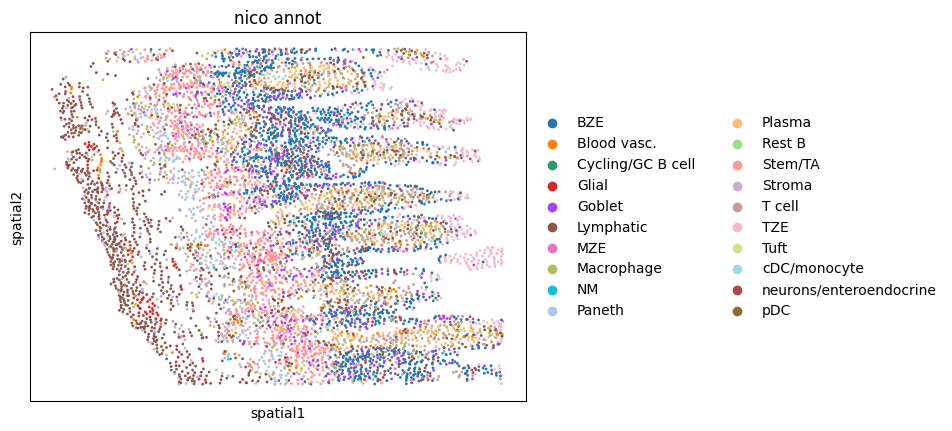

In [5]:
sc.pl.embedding(adata, basis="spatial", color="nico_ct",title='nico annot')


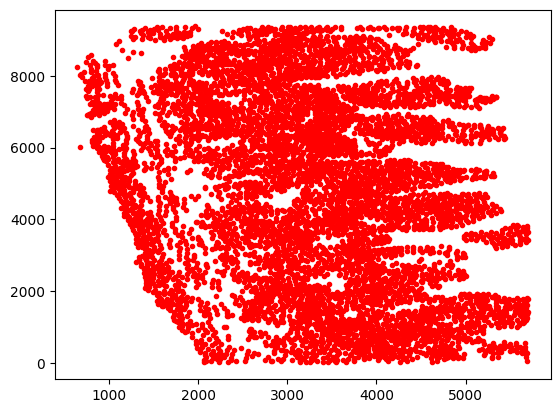

In [6]:
xy=adata.obsm['spatial']
plt.plot(xy[:,0],xy[:,1],'r.')

## To perform differential neighborhood analysis I split the tissue at 5000 y axis to create lower and upper conditions 

In [7]:
cond=np.copy(adata.obs_names)
cond[xy[:,1]<5000]='lower'
cond[xy[:,1]>=5000]='upper'
adata.obs['condition']=pd.Categorical(cond)

In [7]:
#sc.pp.filter_genes(adata, min_cells=1)
#sc.pp.filter_cells(adata, min_counts=3)
#print(adata)

In [8]:
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [9]:
scvi.settings.seed = 12345
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key='sample'
)

model = scvi.model.SCVI(adata)

Global seed set to 12345
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [10]:
model.train(early_stopping=True, enable_progress_bar=True)

Epoch 400/400: 100%|███████████████████████████████████████████| 400/400 [03:24<00:00,  1.96it/s, loss=72.3, v_num=1]


In [11]:
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)


CellCharter’s spatial clustering

In [12]:
sq.gr.spatial_neighbors(adata, library_key='sample', coord_type='generic', delaunay=True)
cc.gr.remove_long_links(adata)

In [13]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', 
                          sample_key='sample')

  0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
autok = cc.tl.ClusterAutoK(
    n_clusters=(8,25), 
    max_runs=50, 
    model_params=dict(
        random_state=14533
        # If running on GPU
        #trainer_params=dict(accelerator='gpu', devices=1)
    )
)

In [15]:
autok.fit(adata, use_rep='X_cellcharter')


Iteration 1/50


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Iteration 2/50


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 3/50


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 4/50


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 5/50


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 6/50


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 7/50


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 8/50


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 9/50


  0%|          | 0/20 [00:00<?, ?it/s]

Convergence with a change in stability of 0.006969788999838623 reached after 9 iterations


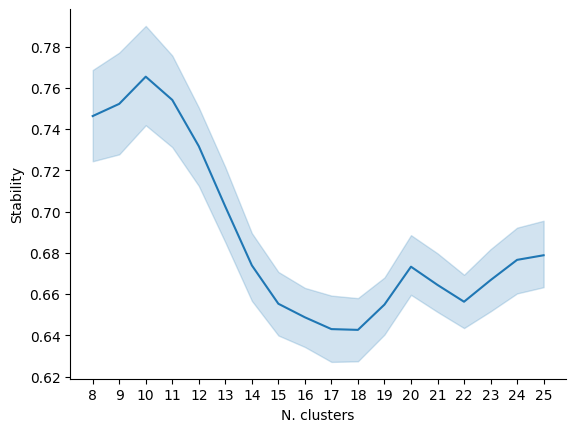

In [16]:
cc.pl.autok_stability(autok)


In [17]:
adata.obs['cluster_cellcharter'] = autok.predict(adata, use_rep='X_cellcharter')


In [19]:
'''
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter'], 
    library_key='sample',  
    size=30, 
    img=None,
    #spatial_key='spatial_fov',
    palette='Set2',
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(15,15),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    #library_id=['Lung9_Rep1'],
)
'''

"\nsq.pl.spatial_scatter(\n    adata, \n    color=['cluster_cellcharter'], \n    library_key='sample',  \n    size=30, \n    img=None,\n    #spatial_key='spatial_fov',\n    palette='Set2',\n    #connectivity_key='spatial_connectivities',\n    #img_alpha=0.3,\n    figsize=(15,15),\n    ncols=1,\n    #library_id=adata.obs['sample'].unique(),\n    #library_id=['Lung9_Rep1'],\n)\n"

In [18]:
np.unique(adata.obs['cluster_cellcharter'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Enrichement of cellcharter domain in the Nico Annotations 

/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:757: RuntimeWarning: invalid value encountered in power
  size = frac**size_exponent


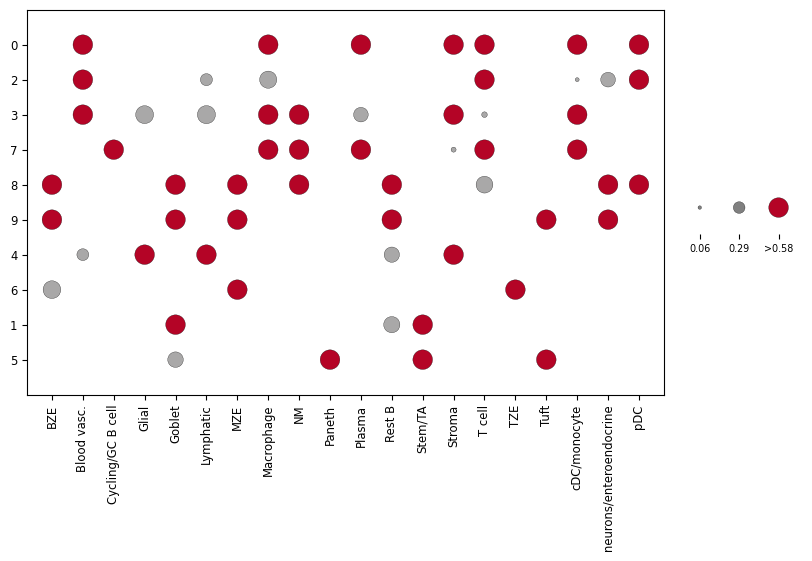

In [19]:

cc.gr.enrichment(adata, group_key='nico_ct', label_key='cluster_cellcharter')
cc.pl.enrichment(adata, group_key='nico_ct', label_key='cluster_cellcharter', color_threshold=0.58, 
                 size_threshold=0.58)

# Proximity analysis 

The next step is to describe the relative arrangement of spatial clusters in the samples and observe whether the relative proximity between spatial clusters changes between the healthy and disease condition. We extract the condition labels from the sample labels.

In [20]:
adata.obs['nico_ct2']=pd.Categorical(adata.obs['nico_ct'])

# Proximity for NiCo annotatation 

/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/pl/_utils.py:93: FutureWarning: Series.__getitem__ treating keys as positions is

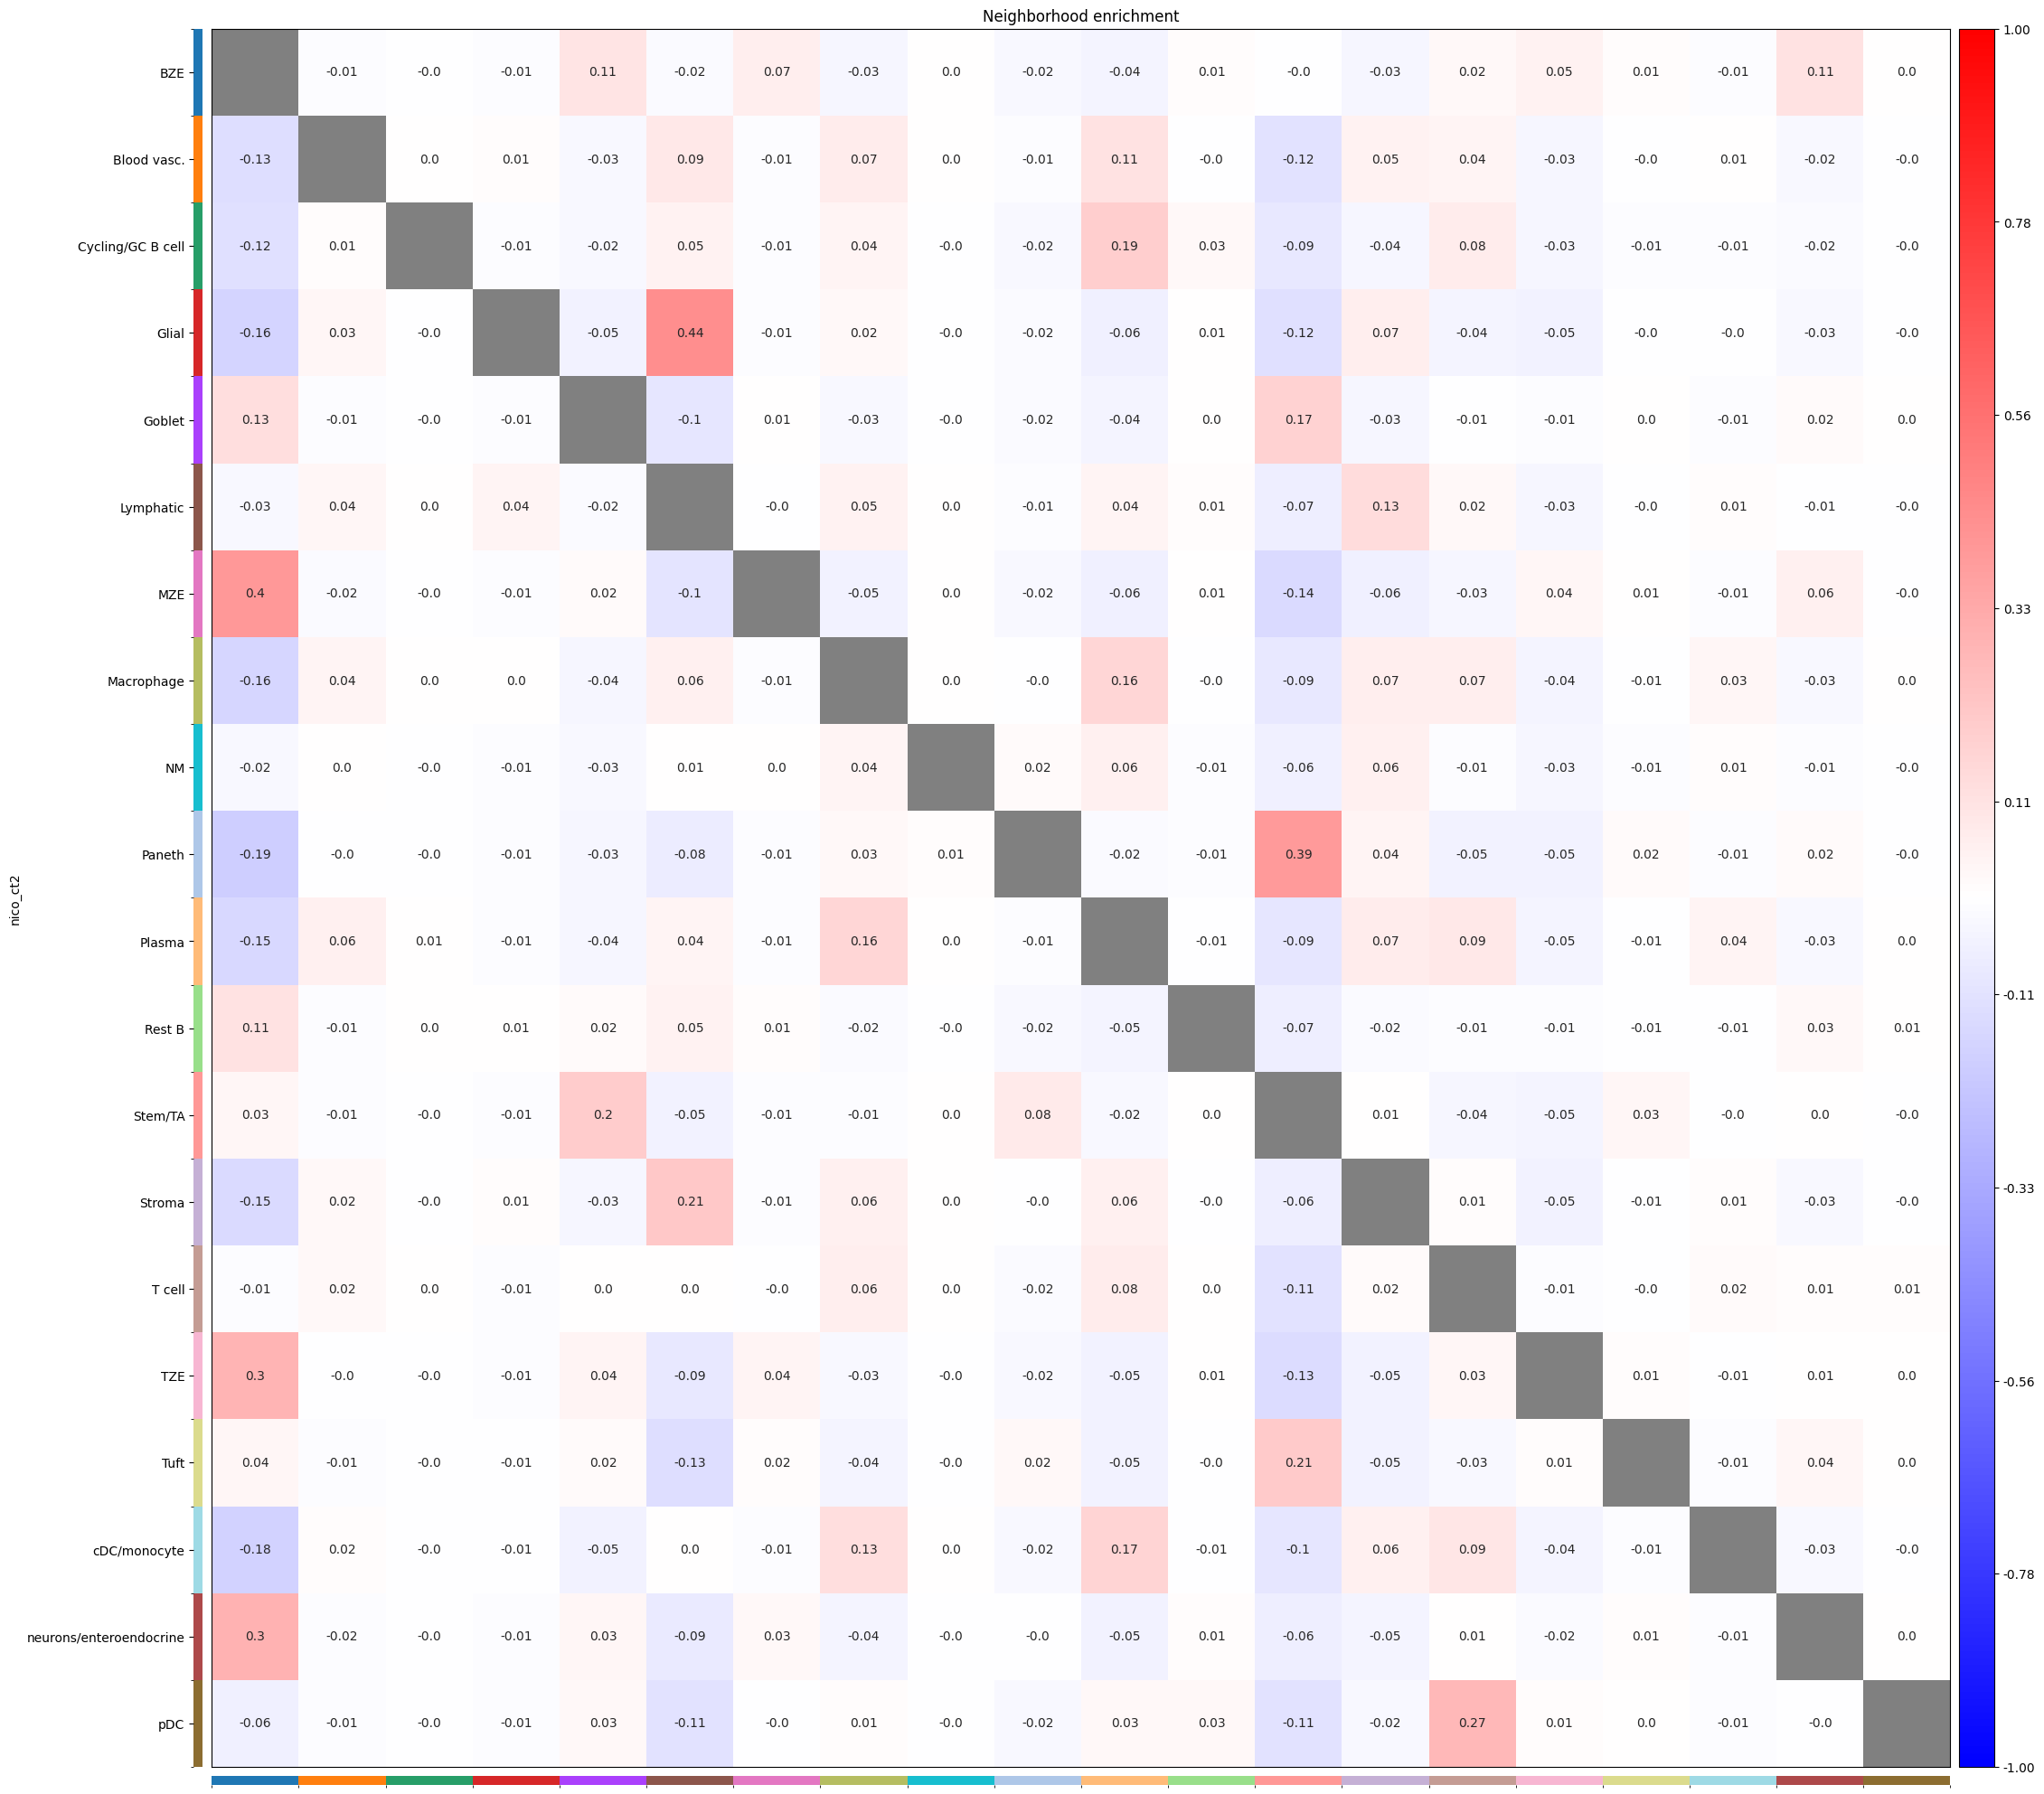

In [21]:
cc.gr.nhood_enrichment(adata,cluster_key='nico_ct2')
cc.pl.nhood_enrichment(adata,cluster_key='nico_ct2',annotate=True,vmin=-1,vmax=1)

# Proximity for Cellcharter domain 

/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  wa

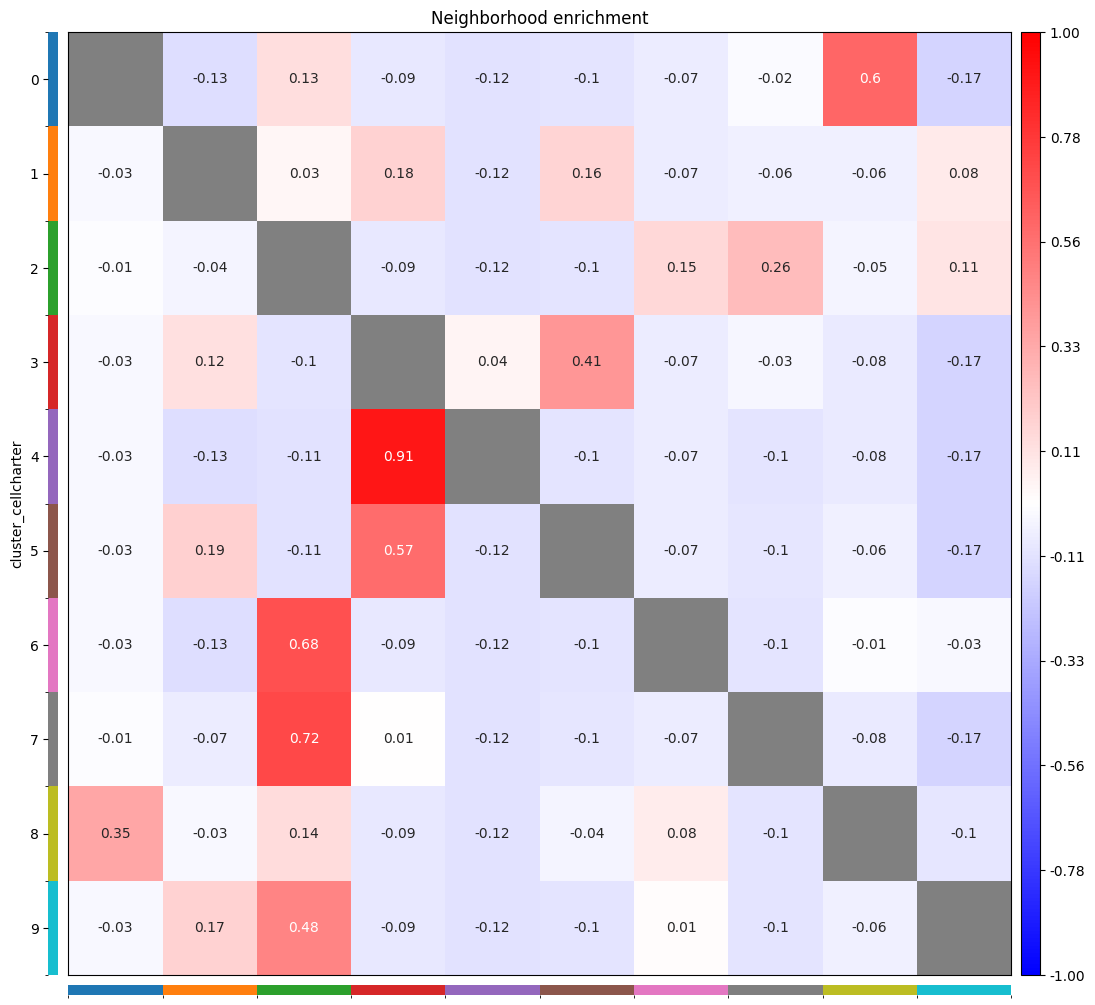

In [22]:
cc.gr.nhood_enrichment(adata,cluster_key='cluster_cellcharter')
cc.pl.nhood_enrichment(adata,cluster_key='cluster_cellcharter',annotate=True,vmin=-1,vmax=1)

In [31]:
# trying to save data but does not work yet 
nadata=adata.copy()
nadata.obs['cluster_cellcharter']=pd.Categorical(nadata.obs['cluster_cellcharter'].astype(int)
#nadata.write_h5ad('cellcharter_intestine.h5ad')
 #nadata.uns['cluster_cellcharter_nhood_enrichment']

SyntaxError: incomplete input (2971058685.py, line 3)

In [34]:
#nadata.write_h5ad('cellcharter_intestine.h5ad')

In [37]:
#sc.pl.umap(adata,  color="nico_ct",title='nico annot')


In [27]:
cc.gr.connected_components(adata, cluster_key='nico_ct2')

In [28]:
cc.tl.boundaries(adata, min_hole_area_ratio=0.1)


In [29]:
cc.tl.linearity(adata)
cc.tl.curl(adata)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


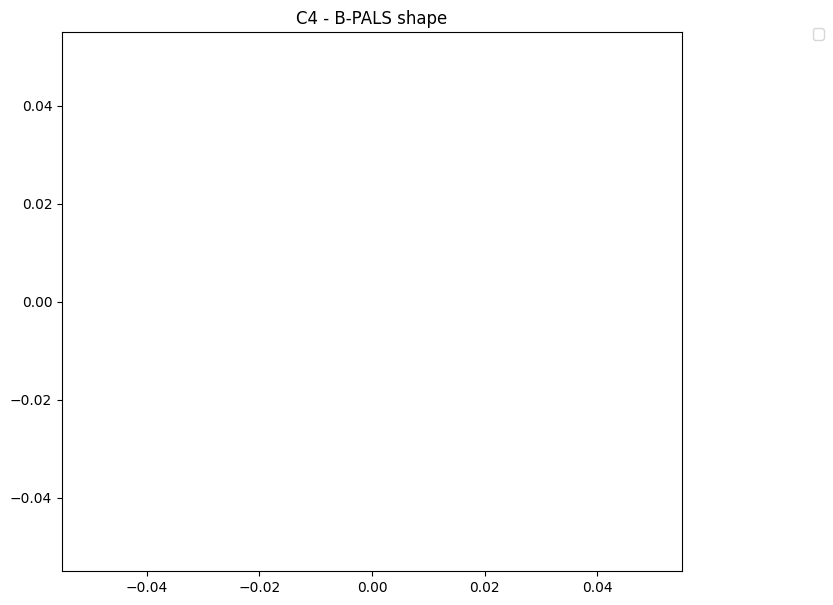

In [34]:
cc.pl.plot_shape_metrics(
    adata, 
    condition_key='condition', 
    condition_groups=['lower', 'upper'],
    cluster_key='cluster_cellcharter', 
    cluster_id=[1], 
    title='C4 - B-PALS shape'
)

## To perform differential neighborhood analysis I split the tissue at 5000 y axis. 

In [23]:
adata

AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'nico_ct', 'sample', 'n_counts', 'condition', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter', 'nico_ct2'
    var: 'n_cells'
    uns: 'nico_ct_colors', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'spatial_neighbors', 'nico_ct_cluster_cellcharter_enrichment', 'nico_ct2_nhood_enrichment', 'cluster_cellcharter_nhood_enrichment'
    obsm: 'spatial', 'X_scVI', 'X_cellcharter'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [26]:
cc.gr.diff_nhood_enrichment(
    adata,
    cluster_key='cluster_cellcharter',
    condition_key='condition',
    library_key='sample',
    pvalues=True,
    n_jobs=15,
    n_perms=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/agrawal/miniconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

KeyError: '0_1'